In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np
import os
from sklearn.model_selection import train_test_split
import sklearn.preprocessing

Using TensorFlow backend.


Fix random seed

In [18]:
seed = np.random.seed(7)

# Get back the convolutional part of a VGG network trained on ImageNet

In [4]:
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

# Create your own input format (here 300x400x3)

In [5]:
input = Input(shape=(400,300,3),name = 'image_input')

# Use the generated model 

In [6]:
output_vgg16_conv = model_vgg16_conv(input)

# Add the fully-connected layers 

In [7]:
x = Flatten(name='flatten')(output_vgg16_conv)
#x = Dense(4096, activation='relu', name='fc1')(x)
#x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(2, activation='softmax', name='predictions')(x)

# Create your own model 

In [8]:
my_model = Model(input=input, output=x)

/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  """Entry point for launching an IPython kernel.


In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training

In [9]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 400, 300, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 55296)             0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 110594    
Total params: 14,825,282
Trainable params: 14,825,282
Non-trainable params: 0
_________________________________________________________________


# Get data for train and test set

In [13]:
np_path = '/home/kevin/Desktop/OpenFoodFacts/data/npy'
imgs_np_path = os.path.join(np_path, 'images.npy')
labels_np_path = os.path.join(np_path, 'labels.npy')
Y = np.load(labels_np_path)
X = np.load(imgs_np_path)

Little work on Y

In [14]:
Y.shape = (2908,1)
b = Y=='1'
a = np.concatenate((b,~b), axis = 1)
Y = a

#a = Y.copy()
#label_binarizer = sklearn.preprocessing.LabelBinarizer()
#label_binarizer.fit(range(2))
#b = label_binarizer.transform(a)
#Y = b

In [15]:
print("The images data shape is {}.".format(X.shape))
print("The labels data shape is {}.".format(Y.shape))

The images data shape is (2908, 400, 300, 3).
The labels data shape is (2908, 2).


Now compile the model

In [16]:
#my_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
my_model.compile(loss='hinge', optimizer='adadelta', metrics=['accuracy'])

Split train and test set

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=seed)

Remove the variables that are now uneseful but who takes lot of space in the RAM

In [20]:
%reset_selective X, Y

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


# Learning phase: fit the model. You can go directly to load model.

In [ ]:
my_model.fit(X_train, y_train, validation_split=0.3, epochs=1, batch_size=10)

Train on 1424 samples, validate on 611 samples
Epoch 1/1
 780/1424 [===============>..............] - ETA: 1142s - loss: 0.8173 - acc: 0.3654

In [16]:
directory = '/home/kevin/Desktop/OpenFoodFacts/data/model'
model_path = os.path.join(directory, 'model.hdf5') 
my_model.save_weights(model_path)

# Load model

In [10]:
directory = '/home/kevin/Desktop/OpenFoodFacts/data/model'
model_path = os.path.join(directory, 'model.hdf5') 
my_model.load_weights(model_path)

In [21]:
scores = my_model.evaluate(X_test, y_test)

873/873 [==============================] - 532s   


In [22]:
print("\n%s: %.2f%%" % (my_model.metrics_names[1], scores[1]*100))


acc: 36.43%


# Understand this low metrics: plot the confusion matrix

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
y_pred = my_model.predict(X_test)
y_pred

array([[  1.87290170e-19,   1.00000000e+00],
       [  1.87290170e-19,   1.00000000e+00],
       [  1.87290170e-19,   1.00000000e+00],
       ..., 
       [  1.87290170e-19,   1.00000000e+00],
       [  1.87290170e-19,   1.00000000e+00],
       [  1.87290170e-19,   1.00000000e+00]], dtype=float32)

Confusion matrix, without normalization
[[  0 318]
 [  0 555]]
Normalized confusion matrix
[[ 0.  1.]
 [ 0.  1.]]


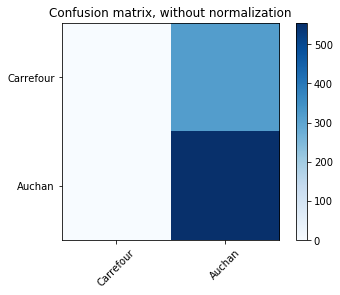

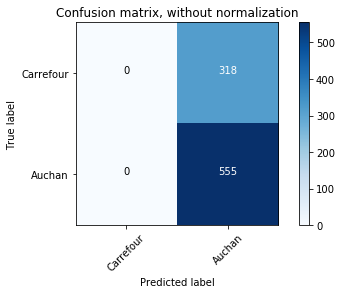

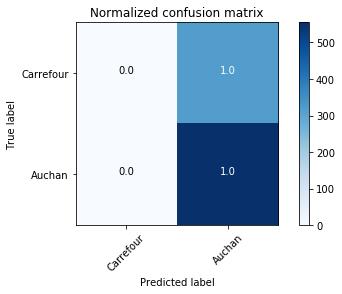

In [44]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.T[0], y_pred.T[0]<0.5)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = ['Carrefour','Auchan']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()